
# Análise de Desempenho e Regressão Linear


In [1]:

import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick

%matplotlib inline



## Parte I – Análise Estatística

In [2]:
# Carregamento e imputação de dados do dataset original

dadosOriginais = pd.read_csv("dataset_11.csv")
dados = dadosOriginais.copy()

print("📁 Arquivo 'dataset_11.csv' carregado com sucesso!")

print("\n🔍 Verificação de valores ausentes por coluna (antes do tratamento):")
faltantesAntes = dados.isnull().sum()
if faltantesAntes.sum() > 0:
    print(faltantesAntes[faltantesAntes > 0])
else:
    print("✅ Nenhuma célula com valor ausente identificada.")

print("\n🔧 Preenchendo colunas numéricas com a mediana...")
colunasNumericasComNa = dados.select_dtypes(include=np.number).isnull().any()
colunasNumericasParaImputar = colunasNumericasComNa[colunasNumericasComNa].index.tolist()
if colunasNumericasParaImputar:
    for coluna in colunasNumericasParaImputar:
        mediana = dados[coluna].median()
        dados[coluna].fillna(mediana, inplace=True)
        print(f"→ Coluna '{coluna}' preenchida com a mediana ({mediana:.2f}).")
else:
    print("✅ Nenhuma coluna numérica com dados ausentes encontrada.")

print("\n🔧 Preenchendo colunas categóricas com a moda...")
colunasCategComNa = dados.select_dtypes(include=['object', 'category']).isnull().any()
colunasCategParaImputar = colunasCategComNa[colunasCategComNa].index.tolist()
if colunasCategParaImputar:
    for coluna in colunasCategParaImputar:
        if not dados[coluna].dropna().empty:
            moda = dados[coluna].mode()[0]
            dados[coluna].fillna(moda, inplace=True)
            print(f"→ Coluna '{coluna}' preenchida com a moda ('{moda}').")
        else:
            print(f"⚠️ A coluna '{coluna}' está vazia ou contém apenas valores nulos, impossibilitando a imputação.")
else:
    print("✅ Nenhuma variável categórica com valores faltantes encontrada.")

print("\n📊 Verificação final de valores ausentes após a imputação:")
faltantesDepois = dados.isnull().sum()
if faltantesDepois.sum() == 0:
    print("✅ Todos os dados ausentes foram preenchidos com sucesso.")
else:
    print("⚠️ Ainda restam valores ausentes nas seguintes colunas:")
    print(faltantesDepois[faltantesDepois > 0])

print("\n📈 Estatísticas Descritivas - Variáveis Numéricas:")
descricaoNumerica = dados.describe(include=np.number)
print(descricaoNumerica)

print("\n📋 Estatísticas Descritivas - Variáveis Categóricas:")
descricaoCateg = dados.describe(include=['object', 'category'])
print(descricaoCateg)

print("\n📊 Frequência das Categorias - 'sistema_operacional':")
print(dados["sistema_operacional"].value_counts())

print("\n📊 Frequência das Categorias - 'tipo_hd':")
print(dados["tipo_hd"].value_counts())

print("\n📊 Frequência das Categorias - 'tipo_processador':")
print(dados["tipo_processador"].value_counts())

# Salvando o novo dataset limpo
dados.to_csv("dataset_11_limpo_replicado_v2.csv", index=False)
print("\n💾 Arquivo final salvo como: 'dataset_11_limpo_replicado_v2.csv'")

# Identificando as colunas numéricas e categóricas finais
colunasNumericas = dados.select_dtypes(include=np.number).columns.tolist()
colunasCateg = dados.select_dtypes(include=['object', 'category']).columns.tolist()

print(f"\n✅ Colunas Numéricas Identificadas: {colunasNumericas}")
print(f"✅ Colunas Categóricas Identificadas: {colunasCateg}")


📁 Arquivo 'dataset_11.csv' carregado com sucesso!

🔍 Verificação de valores ausentes por coluna (antes do tratamento):
latencia_ms         18
armazenamento_tb    18
tipo_hd             18
tempo_resposta       1
dtype: int64

🔧 Preenchendo colunas numéricas com a mediana...
→ Coluna 'latencia_ms' preenchida com a mediana (164.59).
→ Coluna 'armazenamento_tb' preenchida com a mediana (0.51).
→ Coluna 'tempo_resposta' preenchida com a mediana (85.31).

🔧 Preenchendo colunas categóricas com a moda...
→ Coluna 'tipo_hd' preenchida com a moda ('HDD').

📊 Verificação final de valores ausentes após a imputação:
✅ Todos os dados ausentes foram preenchidos com sucesso.

📈 Estatísticas Descritivas - Variáveis Numéricas:
        cpu_cores      ram_gb  latencia_ms  armazenamento_tb  tempo_resposta
count  185.000000  185.000000   185.000000        185.000000      185.000000
mean     8.572973   25.383784   157.138919          0.888173      107.237595
std      4.048124   21.629005    75.645088        

C:\Users\jcmag\AppData\Local\Temp\ipykernel_20588\3968908990.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dados[coluna].fillna(mediana, inplace=True)
C:\Users\jcmag\AppData\Local\Temp\ipykernel_20588\3968908990.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exampl


## Parte II – Modelo e Diagnóstico




### Modelo 1: Regressão Linear Múltipla (Todas as Variáveis)


In [3]:
# Preparação dos dados e ajuste do Modelo 1 (com todas as variáveis)

dadosLimpos = pd.read_csv("dataset_11_limpo_replicado_v2.csv")
colunasCateg = ["sistema_operacional", "tipo_hd", "tipo_processador"]

# Codificação das variáveis categóricas (dummy encoding)
dadosCodificados1 = pd.get_dummies(dadosLimpos, columns=colunasCateg, drop_first=True, dtype=int)

# Separação das variáveis dependente e independentes
y1 = dadosCodificados1["tempo_resposta"]
x1 = dadosCodificados1.drop("tempo_resposta", axis=1)
x1 = sm.add_constant(x1)  # Inclusão do intercepto

# Ajuste do modelo de regressão linear múltipla
modelo1 = sm.OLS(y1, x1)
resultado1 = modelo1.fit()

# Exibição dos resultados
print("=-=-Resumo Estatístico do Modelo 1 (com todas as variáveis)-=-=")
print(resultado1.summary())

# Identificação das categorias base utilizadas na codificação dummy
print("=-=-Categorias de Referência Utilizadas (Dummy Encoding)-=-=")
for coluna in colunasCateg:
    categoriasOriginais = set(dadosLimpos[coluna].unique())
    colunasDummy = {c.split(f'{coluna}_')[-1] for c in x1.columns if c.startswith(f'{coluna}_')}
    categoriaBase = categoriasOriginais - colunasDummy
    if len(categoriaBase) == 1:
        print(f"- {coluna}: A categoria de referência é '{list(categoriaBase)[0]}'")
    else:
        print(f"- {coluna}: Não foi possível determinar uma única base (categorias remanescentes: {categoriaBase})")


=-=-Resumo Estatístico do Modelo 1 (com todas as variáveis)-=-=
                            OLS Regression Results                            
Dep. Variable:         tempo_resposta   R-squared:                       0.669
Model:                            OLS   Adj. R-squared:                  0.654
Method:                 Least Squares   F-statistic:                     44.52
Date:                Tue, 06 May 2025   Prob (F-statistic):           1.93e-38
Time:                        22:28:43   Log-Likelihood:                -935.03
No. Observations:                 185   AIC:                             1888.
Df Residuals:                     176   BIC:                             1917.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------


### Diagnóstico de Multicolinearidade


In [4]:
# Análise de multicolinearidade - cálculo dos VIFs

variaveisVif = x1.drop("const", axis=1)

tabelaVif = pd.DataFrame()
tabelaVif["variavel"] = variaveisVif.columns

try:
    tabelaVif["vif"] = [variance_inflation_factor(variaveisVif.values, i) for i in range(len(variaveisVif.columns))]
except Exception as e:
    print(f"Ocorreu um erro durante o cálculo do VIF: {e}")
    vifs = []
    for i in range(len(variaveisVif.columns)):
        try:
            v = variance_inflation_factor(variaveisVif.values, i)
        except Exception:
            v = float('inf')
        vifs.append(v)
    tabelaVif["vif"] = vifs

print("=-=-Cálculo do Fator de Inflação da Variância (VIF)-=-=")
print(tabelaVif)

print("=-=-Avaliação da Colinearidade com Base no VIF-=-=")
vifElevado = tabelaVif[tabelaVif["vif"] > 10]
vifInfinito = tabelaVif[np.isinf(tabelaVif["vif"])]

if not vifInfinito.empty:
    print("Foram identificadas variáveis com VIF infinito — indicando colinearidade perfeita:")
    print(vifInfinito)
    print("Recomenda-se a exclusão de pelo menos uma dessas variáveis para estabilizar o modelo.")
elif not vifElevado.empty:
    print("Detectada multicolinearidade severa (VIF > 10) nas seguintes variáveis:")
    print(vifElevado)
    print("A retirada de uma ou mais dessas variáveis pode ajudar a reduzir redundâncias.")
else:
    vifModerado = tabelaVif[(tabelaVif["vif"] > 5) & (tabelaVif["vif"] <= 10)]
    if not vifModerado.empty:
        print("Níveis intermediários de colinearidade foram observados (5 < VIF ≤ 10):")
        print(vifModerado)
        print("Acompanhamento é indicado, embora não seja obrigatória intervenção imediata.")
    else:
        print("Nenhuma evidência de multicolinearidade relevante foi encontrada (VIF ≤ 5).")

# Ordenação decrescente para facilitar visualização
vifOrdenado = tabelaVif.sort_values(by="vif", ascending=False)
print("\nVIF - Variáveis ordenadas do maior para o menor valor:")
print(vifOrdenado)


=-=-Cálculo do Fator de Inflação da Variância (VIF)-=-=
                         variavel       vif
0                       cpu_cores  4.423661
1                          ram_gb  2.106876
2                     latencia_ms  3.947534
3                armazenamento_tb  2.517450
4       sistema_operacional_MacOS       inf
5     sistema_operacional_Windows  1.746126
6                     tipo_hd_SSD  1.662376
7  tipo_processador_Apple Silicon       inf
8          tipo_processador_Intel  2.066306
=-=-Avaliação da Colinearidade com Base no VIF-=-=
Foram identificadas variáveis com VIF infinito — indicando colinearidade perfeita:
                         variavel  vif
4       sistema_operacional_MacOS  inf
7  tipo_processador_Apple Silicon  inf
Recomenda-se a exclusão de pelo menos uma dessas variáveis para estabilizar o modelo.

VIF - Variáveis ordenadas do maior para o menor valor:
                         variavel       vif
4       sistema_operacional_MacOS       inf
7  tipo_processador_App

c:\Users\jcmag\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)



### Diagnóstico de Heterocedasticidade


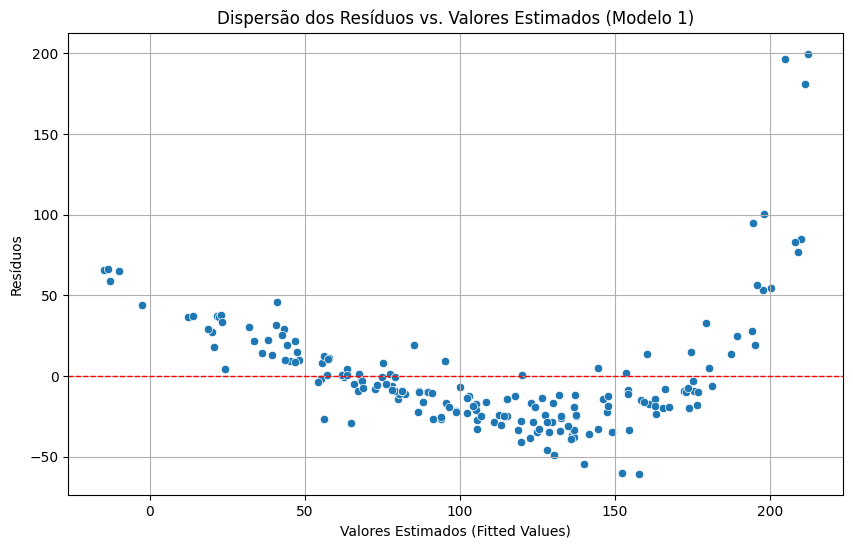

Figura exportada como: residuos_vs_estimados_modelo1.png
=-=-Aplicação do Teste de Breusch-Pagan (Modelo 1)-=-=
Estatística LM (Lagrange Multiplier): 18.2647
p-valor associado (LM): 0.0322
Estatística F: 2.4099
p-valor associado (F): 0.0171
Conclusão: Como o p-valor F (0.0171) é inferior a 0.05, rejeita-se a hipótese nula.
Evidencia-se a presença de heterocedasticidade no modelo.


In [5]:
# Análise de resíduos e diagnóstico de heterocedasticidade

residuosModelo1 = resultado1.resid
valoresEstimados = resultado1.fittedvalues

plt.figure(figsize=(10, 6))
sns.scatterplot(x=valoresEstimados, y=residuosModelo1)
plt.axhline(0, color="red", linestyle="--", linewidth=1)
plt.title("Dispersão dos Resíduos vs. Valores Estimados (Modelo 1)")
plt.xlabel("Valores Estimados (Fitted Values)")
plt.ylabel("Resíduos")
plt.grid(True)
plt.savefig("residuos_vs_estimados_modelo1.png")
plt.show()
print("Figura exportada como: residuos_vs_estimados_modelo1.png")

# Teste de Breusch-Pagan para heterocedasticidade
print("=-=-Aplicação do Teste de Breusch-Pagan (Modelo 1)-=-=")
testeBreuschPagan = sms.het_breuschpagan(residuosModelo1, resultado1.model.exog)
nomesEstatisticas = ["Estatística LM", "p-valor LM", "Estatística F", "p-valor F"]
resultadoBreuschPagan = dict(zip(nomesEstatisticas, testeBreuschPagan))

print(f"Estatística LM (Lagrange Multiplier): {resultadoBreuschPagan['Estatística LM']:.4f}")
print(f"p-valor associado (LM): {resultadoBreuschPagan['p-valor LM']:.4f}")
print(f"Estatística F: {resultadoBreuschPagan['Estatística F']:.4f}")
print(f"p-valor associado (F): {resultadoBreuschPagan['p-valor F']:.4f}")

# Interpretação do resultado do teste
nivelSignificancia = 0.05
if resultadoBreuschPagan["p-valor F"] < nivelSignificancia:
    print(f"Conclusão: Como o p-valor F ({resultadoBreuschPagan['p-valor F']:.4f}) é inferior a {nivelSignificancia}, rejeita-se a hipótese nula.")
    print("Evidencia-se a presença de heterocedasticidade no modelo.")
else:
    print(f"Conclusão: Com p-valor F ({resultadoBreuschPagan['p-valor F']:.4f}) ≥ {nivelSignificancia}, não há base suficiente para rejeitar H0.")
    print("Não foram detectados indícios de heterocedasticidade.")



## Parte III – Análise Crítica



### Comparação de Modelos


=-=-Resumo do Modelo 2 (com 'Apple Silicon' removido)-=-=
                            OLS Regression Results                            
Dep. Variable:         tempo_resposta   R-squared:                       0.669
Model:                            OLS   Adj. R-squared:                  0.654
Method:                 Least Squares   F-statistic:                     44.52
Date:                Tue, 06 May 2025   Prob (F-statistic):           1.93e-38
Time:                        22:28:43   Log-Likelihood:                -935.03
No. Observations:                 185   AIC:                             1888.
Df Residuals:                     176   BIC:                             1917.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------

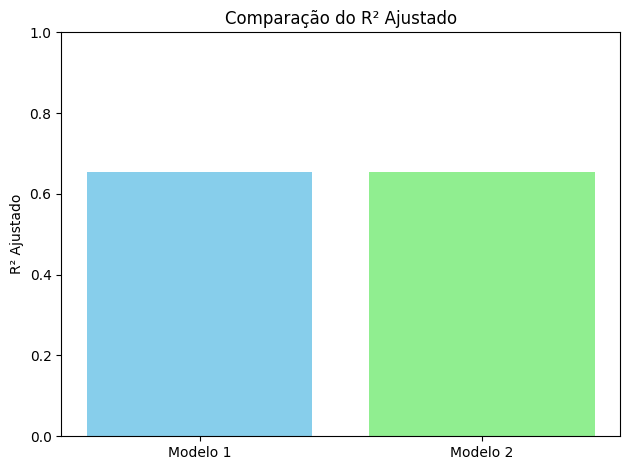

In [6]:
# Modelo 2 (Excluindo variável com VIF infinito)

dadosCodificados2 = pd.get_dummies(dadosLimpos, columns=colunasCateg, drop_first=True, dtype=int)

variaveisParaRemover = ["tempo_resposta", "tipo_processador_Apple Silicon"]
x2 = dadosCodificados2.drop(columns=variaveisParaRemover)
y2 = dadosCodificados2["tempo_resposta"]

x2 = sm.add_constant(x2)
modelo2 = sm.OLS(y2, x2)
resultado2 = modelo2.fit()

print("=-=-Resumo do Modelo 2 (com 'Apple Silicon' removido)-=-=")
print(resultado2.summary())

print("=-=-Comparativo entre os Modelos-=-=")
print(f"Modelo 1: R² Ajustado = {resultado1.rsquared_adj:.4f}, Estatística F = {resultado1.fvalue:.2f}, p-valor (F) = {resultado1.f_pvalue:.2e}, Número de Condição = {np.linalg.cond(x1):.2e}")
print(f"Modelo 2: R² Ajustado = {resultado2.rsquared_adj:.4f}, Estatística F = {resultado2.fvalue:.2f}, p-valor (F) = {resultado2.f_pvalue:.2e}, Número de Condição = {np.linalg.cond(x2):.2f}")

print("=-=-Análise e Escolha do Modelo-=-=")
if resultado2.rsquared_adj >= resultado1.rsquared_adj - 0.01:
    print("O Modelo 2 apresenta desempenho semelhante ao Modelo 1 em termos de R² ajustado.")
    print("Além disso, o Modelo 2 elimina o problema crítico de multicolinearidade, resultando em um número de condição bem mais estável.")

    pValorRemovida = resultado1.pvalues.get('tipo_processador_Apple Silicon', 1)
    if pValorRemovida > 0.05:
        print(f"A variável descartada ('tipo_processador_Apple Silicon') não era estatisticamente relevante no Modelo 1 (p={pValorRemovida:.3f}).")
        print("Portanto, o Modelo 2 se destaca por ser mais enxuto e confiável.")
    else:
        print(f"A variável retirada ('tipo_processador_Apple Silicon') até apresentou significância estatística (p={pValorRemovida:.3f}), porém estava associada a colinearidade extrema.")
        print("Nesse contexto, o Modelo 2 ainda é a escolha mais apropriada por oferecer estimativas mais estáveis.")
else:
    print("O Modelo 2 teve uma redução perceptível no R² ajustado em relação ao Modelo 1.")
    print("Contudo, o Modelo 1 apresenta sérios indícios de multicolinearidade.")
    print("Mesmo com a ligeira perda de explicabilidade, o Modelo 2 é mais seguro por evitar dependência linear entre variáveis.")

# Comparação visual dos modelos
plt.bar(["Modelo 1", "Modelo 2"], [resultado1.rsquared_adj, resultado2.rsquared_adj], color=["skyblue", "lightgreen"])
plt.title("Comparação do R² Ajustado")
plt.ylabel("R² Ajustado")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()
